In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# PSD code
from scipy import signal
from scipy import interpolate
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

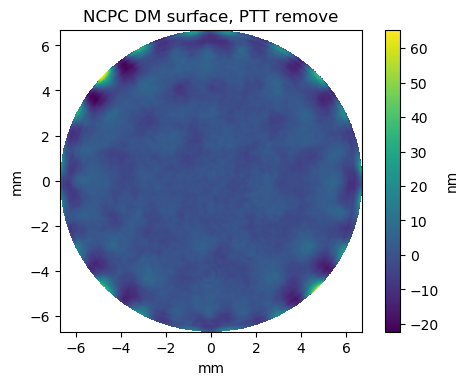

In [2]:
ncpc_raw = fits.open('zygo_data/DM/ncpc_flat.fits')[0].data * u.micron
ncpc_pixscl = (0.017219388 * u.mm).to(u.m)/u.pix

# resize the matrix. Zygo does weird things with size of data.
# numbers and sides determined from probing, already deleted.
ncpc_dm = ncpc_raw[:, 3:ncpc_raw.shape[1]-1]

# make a mask
cen = int(ncpc_dm.shape[0]/2)
yy, xx = np.mgrid[-cen:cen, -cen:cen]
mask = (yy**2 + xx**2 <= cen**2)

# aply mask to wfdm
ncpc_dm = ncpc_dm*mask

# show surface
dfx.show_image(data=dfx.sn_map((ncpc_dm.to(u.nm)).value, mask),
               data_unit=u.nm,
               pixscale=(ncpc_pixscl*u.pix).to(u.mm),
               fig_title='NCPC DM surface, PTT remove')

In [3]:
(ncpc_dm.shape[0]*ncpc_pixscl*u.pix).to(u.mm)/13.5

<Quantity 0.99489797 mm>

In [4]:
%%time
# now calculate the PSD
ncpc = psd.surfPSD(surf_name='NCPC DM')
ncpc.load_surf(data=ncpc_dm, wavelen=632e-9*u.m, latres=ncpc_pixscl)
ncpc.load_mask(mask=mask)
ncpc.calc_psd(oversamp=4096)
ncpc.calc_psd_radial(ring_width=3, kmin=ncpc.k_min)

CPU times: user 3min 45s, sys: 1min 15s, total: 5min
Wall time: 5min


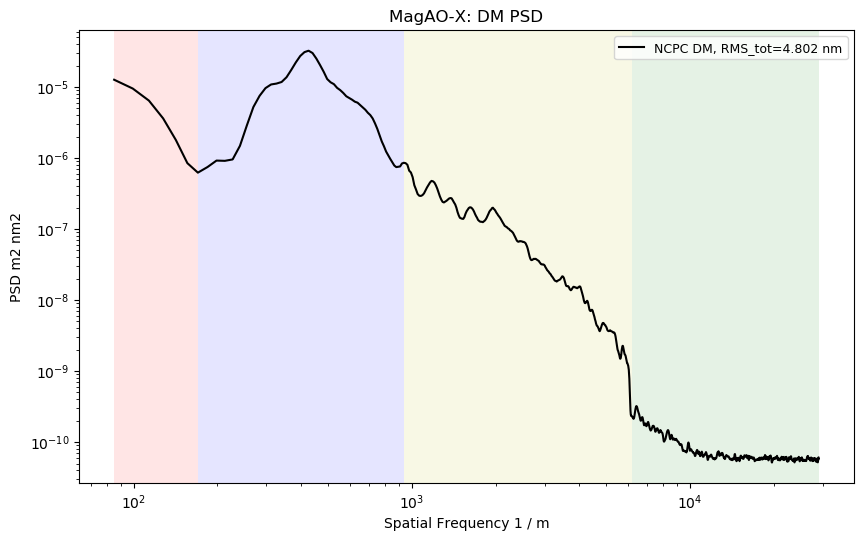

In [15]:
# region selection
ist = [0, 6, 60, 430]
#iend = [30, 390]
iend = ist[1:]
iend.append(len(ncpc.k_radial)-1)
color_list=['r', 'b', 'y', 'g', 'c']
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(ncpc.k_radial.value, ncpc.psd_radial_cal.value, 'k', 
           label='{0}, RMS_tot={1:.3f}'.format(ncpc.surf_name, ncpc.rms_tot))
for j in range(0, len(ist)):
    plt.axvspan(ncpc.k_radial[ist[j]].value, ncpc.k_radial[iend[j]].value, facecolor=color_list[j], alpha=0.1)
plt.xlabel('Spatial Frequency {0}'.format(ncpc.k_radial.unit))
plt.ylabel('PSD {0}'.format(ncpc.psd_radial_cal.unit))
plt.title('MagAO-X: DM PSD')
plt.legend(prop={'size':9})

CPU times: user 2.28 s, sys: 19.4 ms, total: 2.3 s
Wall time: 1.64 s


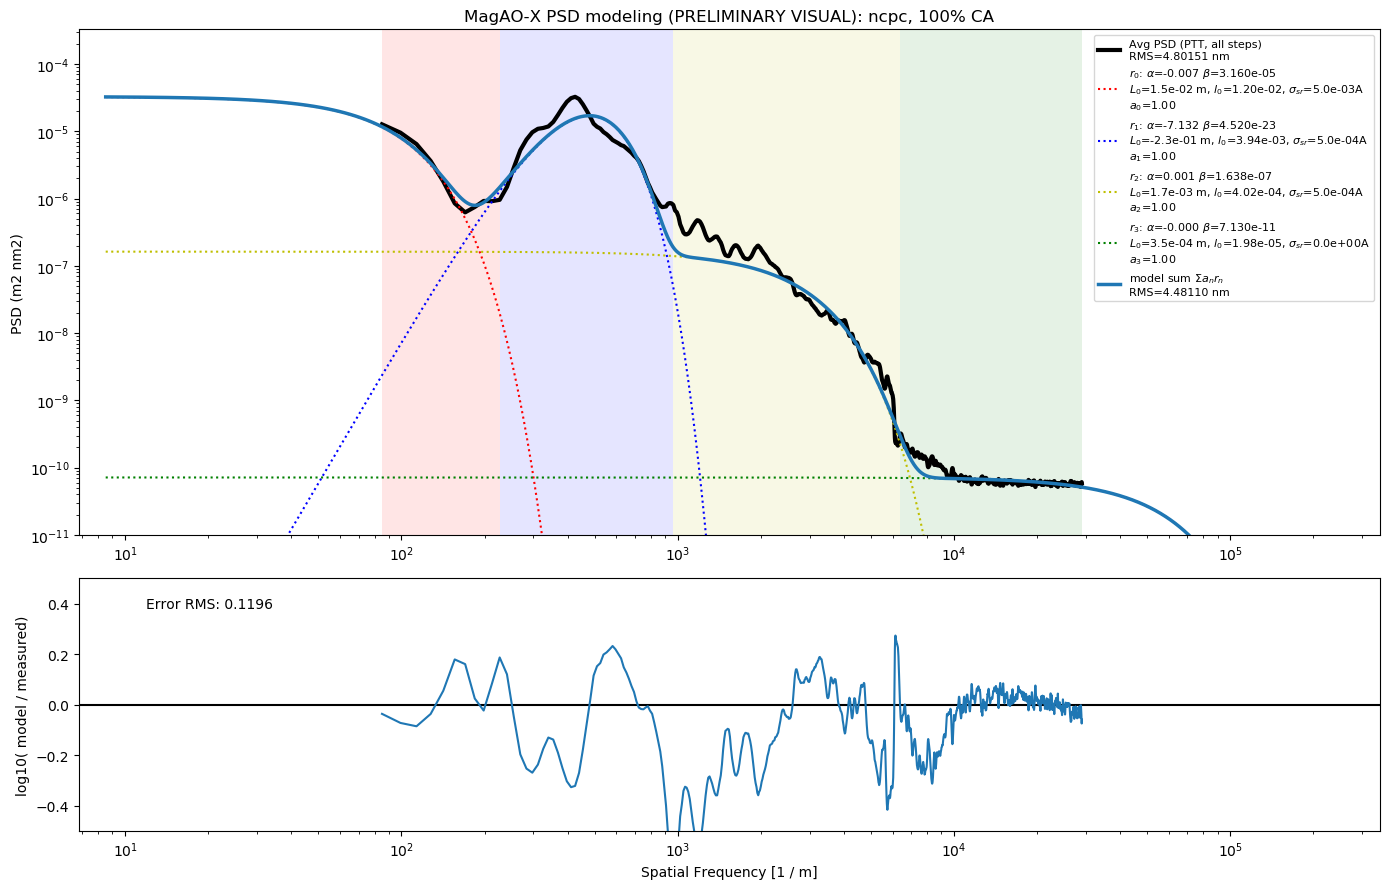

In [54]:
%%time
opt_parms = {'ca' : 100, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': (ncpc_dm.shape[0]*ncpc_pixscl*u.pix),
             'label': 'ncpc',
             'surf_units': u.micron,
             'ring_width': 3,
             'kmid_ll': 100/u.m, #0.1/u.mm,
             'khigh_ll': 1000/u.m} #1/u.mm}

# add in values to opt_parms to make code easier to use
opt_parms['dk'] = ncpc.delta_k
opt_parms['diam_ca'] = ncpc.diam_ca
opt_parms['diam_pix'] = ncpc.npix_diam
opt_parms['wavelen'] = ncpc.wavelen

ist = [0, 10, 62, 442]
iend = ist[1:]
iend.append(len(ncpc.k_radial)-1)
rms_sr = [0.0005*u.nm, 0.00005*u.nm, 0.00005*u.nm, 0.00000*u.nm]
psd_weight = [1.0, 1.0, 1.0, 1.0]
k_limit = [np.amin(ncpc.k_radial)/10, np.amax(ncpc.k_radial)*10]
surf_unit = (ncpc.psd_radial_cal.unit * (ncpc.k_radial.unit**2))**(0.5)
mdl_set=[]
x0 = [[1.0e-3, 1.0e-3, 1.0e-3, 1.0e-3],
      [1.0e-3, 1.0e-3, 1.0e-5, 1.0e-6],
      [1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5],
      [1.0e-4, 1.0e-4, 1.0e-4, 1.0e-4]]
for j in range(0, len(ist)):
    mdl = psd.model_single(region_num=j)
    mdl.load_data(ind_range=[ist[j],iend[j]], psd_obj=ncpc)
    mdl.calc_psd_parm(rms_sr=rms_sr[j], x0=x0[j])#, ratio_mode=False)
    mdl.calc_model_total(psd_weight=psd_weight[j], k_spacing=opt_parms['dk']*0.2, k_limit=k_limit)
    mdl_set.append(mdl)

# model sum with a total refit
ms_refit = psd.model_combine(mdl_set=mdl_set, avg_psd=ncpc)
ms_refit.calc_refit()
ms_refit.calc_error()
ms_refit.calc_psd_rms()

psd.plot_model2(mdl_set, ms_refit, ncpc, opt_parms)

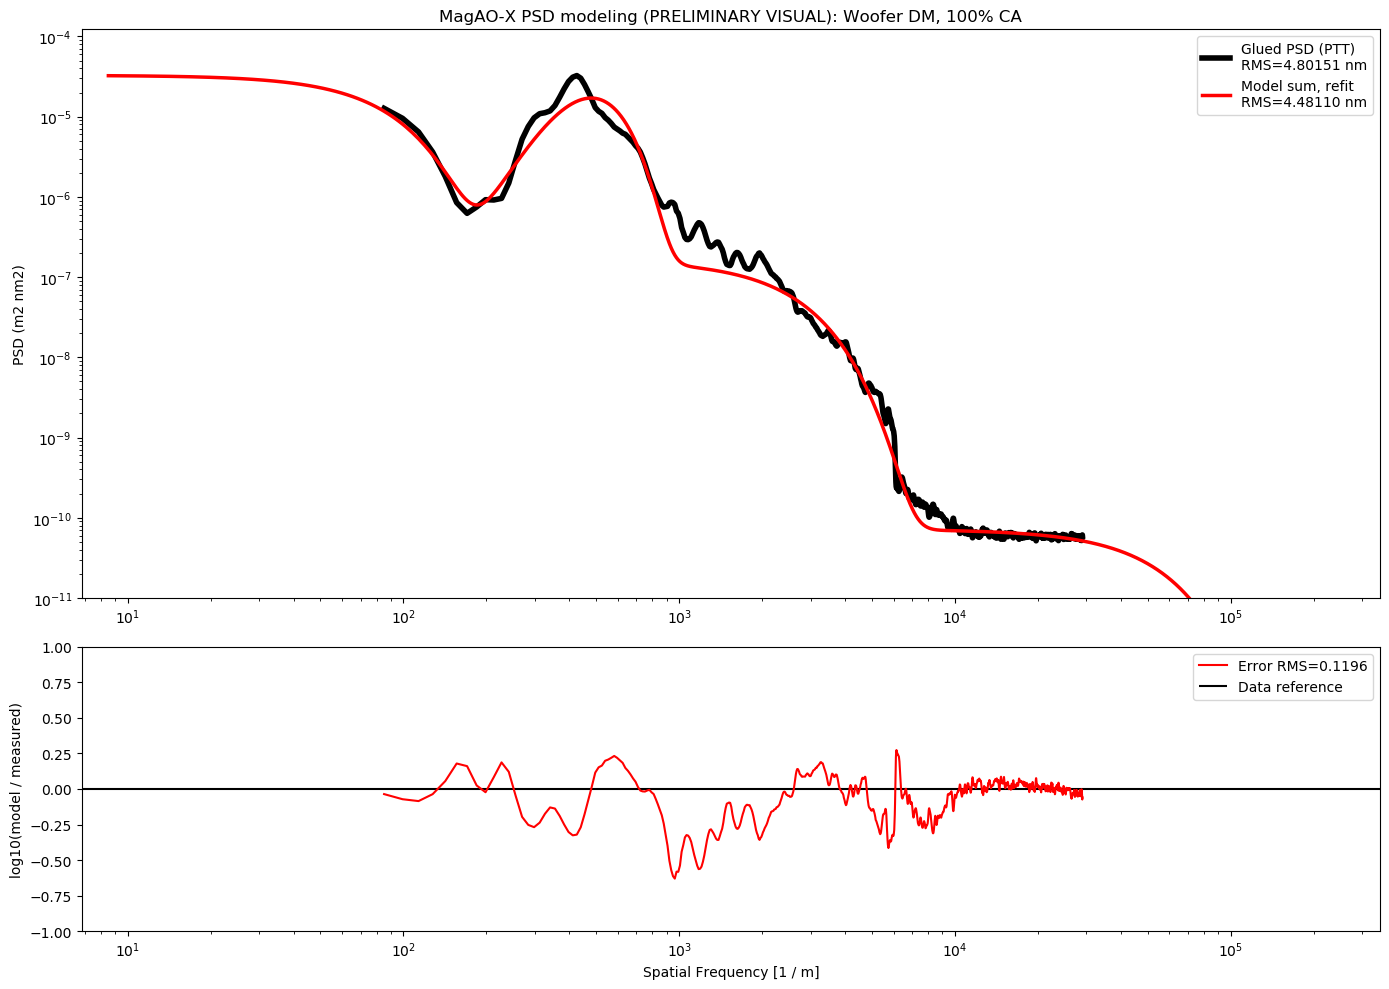

In [55]:
k_radial = ncpc.k_radial.value
psd_radial = ncpc.psd_radial_cal.value
k_range_mdl = mdl_set[0].k_range.value
from matplotlib import gridspec
plt.figure(figsize=[14,10],dpi=100)
gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[4,2])
ax0 = plt.subplot(gs[0])  
ax0.loglog(k_radial, psd_radial, 'k', linewidth=4, 
           label='Glued PSD (PTT)\nRMS={0:.5f}'.format(ncpc.rms_tot))
ax0.loglog(k_range_mdl, ms_refit.psd_radial_sum.value, 'r', linewidth=2.5, 
           label='Model sum, refit\nRMS={0:.5f}'.format(ms_refit.psd_rms_sum))
ax0.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax0.set_ylim(bottom=1e-11)
ax0.set_ylabel('PSD ({0})'.format(ms_refit.psd_radial_sum.unit))
ax0.legend(prop={'size':10})#,loc='center left', bbox_to_anchor=(1, 0.5))
ax0.set_title('MagAO-X PSD modeling (PRELIMINARY VISUAL): Woofer DM, {0}% CA'.format(opt_parms['ca']))

ax1 = plt.subplot(gs[1])
ax1.hlines(y=0, xmin=np.amin(k_range_mdl)*0.8, xmax=np.amax(k_range_mdl)*1.2, color='k', label='Data reference')
ax1.semilogx(k_radial, ms_refit.error, 'r', label='Error RMS={0:.4f}'.format(ms_refit.error_rms))
ax1.legend(prop={'size':10})
ax1.set_ylim(top=1, bottom=-1)
ax1.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax1.set_ylabel('log10(model / measured)')
ax1.set_xlabel('Spatial Frequency [{0}]'.format(ms_refit.k_radial_data.unit))

plt.tight_layout()

In [56]:
# Save the PSD values into a pickle to access later
psd_dict = {'psd_dmncpc': ms_refit.psd_parm,
            'psd_dmncpc_weight': psd_weight}

# save the directory as a pickle
import pickle
filename='/home/jhen/XWCL/code/MagAOX/PSD/psd_parms_dm{0}.pickle'.format(opt_parms['label'])
with open(filename,'wb') as psd_parameter_file:
    pickle.dump(psd_dict, psd_parameter_file, protocol=4)

In [57]:
# test the pickle
objects = []
with (open(filename, "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
            
objects

[{'psd_dmncpc': [[-0.007176971205745668,
    <Quantity 3.15997425e-05 m(2.0071769712057455) nm2>,
    <Quantity 0.01473022 m>,
    0.012006946061918315,
    <Quantity 9.43818328e-17 m2 nm2>],
   [-7.1322779904873785,
    <Quantity 4.52027094e-23 m(9.132277990487378) nm2>,
    <Quantity -0.23102563 m>,
    0.003936799301457586,
    <Quantity 9.43818328e-19 m2 nm2>],
   [0.0011851619379225973,
    <Quantity 1.63830923e-07 m(1.9988148380620774) nm2>,
    <Quantity 0.00171749 m>,
    0.0004015038991288642,
    <Quantity 9.43818328e-19 m2 nm2>],
   [-0.0004872024874731274,
    <Quantity 7.13043204e-11 m(2.000487202487473) nm2>,
    <Quantity 0.00035314 m>,
    1.984480682148527e-05,
    <Quantity 0. m2 nm2>]],
  'psd_dmncpc_weight': [1.0, 1.0, 1.0, 1.0]}]